In [56]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
groq_api_key = os.getenv('GROQ_API_KEY')

In [77]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", api_key=groq_api_key)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x129a5a810>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x129a5b8f0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [78]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

wiki_wrapper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=wiki_wrapper)

arxiv_wrapper = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [79]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'AI Daily News March 03 2025: Nvidia CEO - Apple Podcasts',
  'url': 'https://podcasts.apple.com/ca/podcast/ai-daily-news-march-03-2025-nvidia-ceo-us-ai-chips/id1684415169?i=1000697521476',
  'content': "AI Unraveled: Latest AI News & Trends, ChatGPT, Gemini, DeepSeek, Gen AI, LLMs, AI Ethics & Bias\n\n# AI Daily News March 03 2025: ð\x9f\x9a\x80 Nvidia CEO: US AI Chips Are 60x Faster Than Chinaâ\x80\x99s ð\x9f\x8d\x8fApple's Siri Overhaul Facing Major Delays ð\x9f\x8e\x99ï¸\x8fNew AI Voice to Cross â\x80\x98Uncanny Valleyâ\x80\x99 ð\x9f\x8e¥Sora Video AI Coming to ChatGPT ð\x9f§ªAI Detects Colorect [...] Nvidia claims a significant lead in AI chip speed over China, while Apple faces delays in its Siri AI overhaul. New AI applications are emerging, including highly realistic voice generation, automated resume screening, and AI cardiologists in China.OpenAI plans to integrate Sora video AI into ChatGPT, and large investments are being made in AI by companies like Honor and So

In [80]:
tools = [tavily, wikipedia, arxiv]

In [81]:
llm_with_tools = llm.bind_tools(tools)

In [97]:
from typing_extensions import TypedDict
from pydantic import BaseModel
from typing import Literal, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages


class State(BaseModel):
    messages:Annotated[list[AnyMessage], add_messages]

In [102]:
from IPython.display import display, Image
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state:State):
    #return{"messages":[llm_with_tools.invoke(state['messages'])]} # this is for TypedDict
    return{"messages":[llm_with_tools.invoke(state.messages)]}  # this is for pydentic

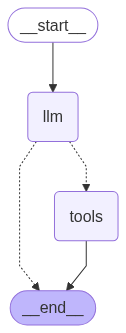

In [103]:
builder = StateGraph(State)
builder.add_node("llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, 'llm')
builder.add_conditional_edges('llm', tools_condition)
builder.add_edge('tools', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [104]:
from langchain_core.messages import HumanMessage
messages= graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_1d4a5e09-e0ba-4e83-9e4c-014d8e817366)
 Call ID: fc_1d4a5e09-e0ba-4e83-9e4c-014d8e817366
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
